#Data preprocessing

In [70]:
!source venv/bin/activate

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

zsh:source:1: no such file or directory: venv/bin/activate


In [71]:
path = '../data/'
df = pd.read_csv(path+'insurance.csv')
df_encoded = df.copy()
df_encoded.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


##Feature engineering

Now that we have some infos about our datas, we can make feature engineering.  
It’s the possible way to create new features from previous features (bases on intuition) to train the model much more.  
We compute $x1*x2$ to find $x3$


Here, some feature interest us :  
- smoker(yes) : strongest correlation : $0.79$
- age : 2nd correlation : $0.30$
- bmi : 3rd correlation : $0.29$

So, from these features, we can do some engineering.  
Our model will be smarter because he could catch non-linear relations.

In [72]:
# one-hot-encoding smokers
df_encoded['smoker'] = df_encoded['smoker'].map({'yes': 1, 'no': 0})
# one-hot-encoding sex
df_encoded['sex'] = df_encoded['sex'].map({'male': 1, 'female': 0})
# for 'region' which has multiple categories, use one-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=['region'], drop_first=True)

df_encoded.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


We splitted regions into 3 columns with name of regions (one-hot-encoding) with True/False

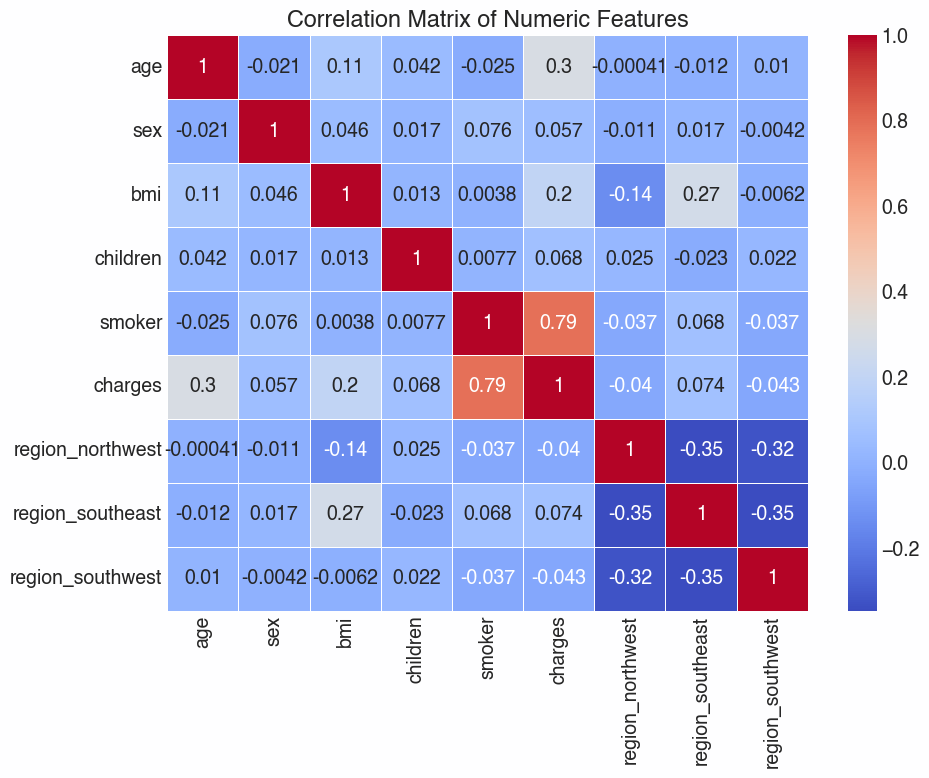

In [73]:
# correlation matrix
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

Correlation matrix shows us :
- a strong correlation between smoker & charges ($>0.7$)
- a moderate correlation between age & bmi 
- a little correlation between region_southeast & bmi 
- a little correlation between age & charges

So, we have to take the strongest corr feature with target and create engineered features with other features from it.  
We can also squared moderate corr features (with target)

Log the target is also a good practice when the distribution is right-skewed with many moderate values and fewer extreme high values.  
The logarithmic make distribution more normal : improving model performance (by creating more linear relationship)

In [74]:
# interaction features based on correlation insights
df_encoded['age_bmi'] = df_encoded['age'] * df_encoded['bmi']  # Interaction between age and BMI
df_encoded['smoker_age'] = df_encoded['smoker'] * df_encoded['age']  # Interaction between smoking and age
df_encoded['smoker_bmi'] = df_encoded['smoker'] * df_encoded['bmi']  # Interaction between smoking and BMI

# polynomial features for important variables
df_encoded['bmi_squared'] = df_encoded['bmi'] ** 2  # Quadratic term for BMI
df_encoded['age_squared'] = df_encoded['age'] ** 2  # Quadratic term for age

# log transform for skewed variables (like charges)
df_encoded['log_charges'] = np.log1p(df_encoded['charges'])  # log1p to handle zeros

df_encoded.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest,age_bmi,smoker_age,smoker_bmi,bmi_squared,age_squared,log_charges
0,19,0,27.900,0,1,16884.92400,False,False,True,530.100,19,27.9,778.410000,361,9.734236
1,18,1,33.770,1,0,1725.55230,False,True,False,607.860,0,0.0,1140.412900,324,7.453882
2,28,1,33.000,3,0,4449.46200,False,True,False,924.000,0,0.0,1089.000000,784,8.400763
3,33,1,22.705,0,0,21984.47061,True,False,False,749.265,0,0.0,515.517025,1089,9.998137
4,32,1,28.880,0,0,3866.85520,True,False,False,924.160,0,0.0,834.054400,1024,8.260455


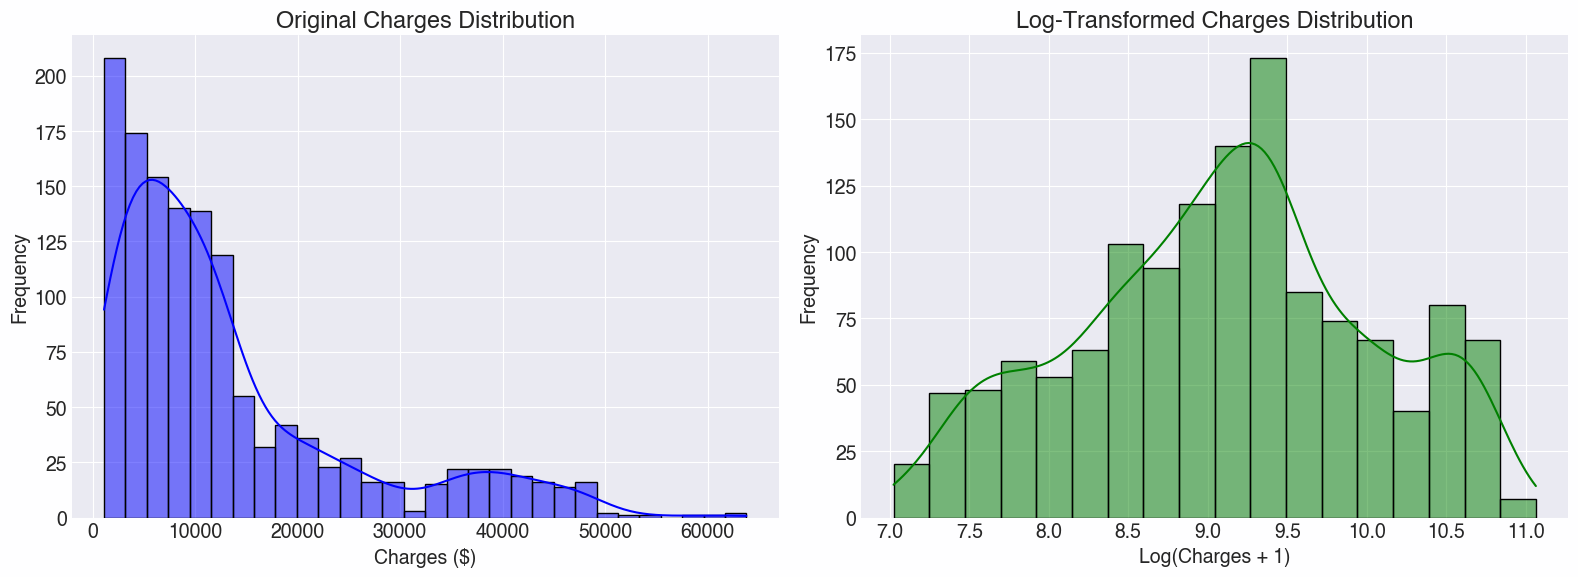


Skewness - Original Charges: 1.5158796580240388
Skewness - Log Charges: -0.08981728740026824


In [75]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Original charges distribution
sns.histplot(df_encoded['charges'], kde=True, ax=ax1, color='blue')
ax1.set_title('Original Charges Distribution')
ax1.set_xlabel('Charges ($)')
ax1.set_ylabel('Frequency')

# Plot 2: Log-transformed charges distribution
sns.histplot(df_encoded['log_charges'], kde=True, ax=ax2, color='green')
ax2.set_title('Log-Transformed Charges Distribution')
ax2.set_xlabel('Log(Charges + 1)')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate and print skewness
print("\nSkewness - Original Charges:", df_encoded['charges'].skew())
print("Skewness - Log Charges:", df_encoded['log_charges'].skew())

##Scaling

In [76]:
# select features except the target variable
features = df_encoded.drop(['charges', 'log_charges'], axis=1)
target = df_encoded['charges']
log_target = df_encoded['log_charges']

# apply scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# convert back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)


Verify if values are in a small range (normalized)

Means of scaled features:
age                -1.805565e-16
sex                -1.234687e-16
bmi                -2.124194e-16
children           -5.576008e-17
smoker              1.062097e-17
region_northwest    1.062097e-16
region_southeast   -1.062097e-17
region_southwest    1.035544e-16
age_bmi            -1.062097e-17
smoker_age         -4.646673e-17
smoker_bmi          2.788004e-17
bmi_squared         1.035544e-16
age_squared        -9.293347e-17
dtype: float64

Standard deviations of scaled features:
age                 1.000374
sex                 1.000374
bmi                 1.000374
children            1.000374
smoker              1.000374
region_northwest    1.000374
region_southeast    1.000374
region_southwest    1.000374
age_bmi             1.000374
smoker_age          1.000374
smoker_bmi          1.000374
bmi_squared         1.000374
age_squared         1.000374
dtype: float64

Minimum values:
age                -1.509965
sex                -1.010519
bmi                -2.

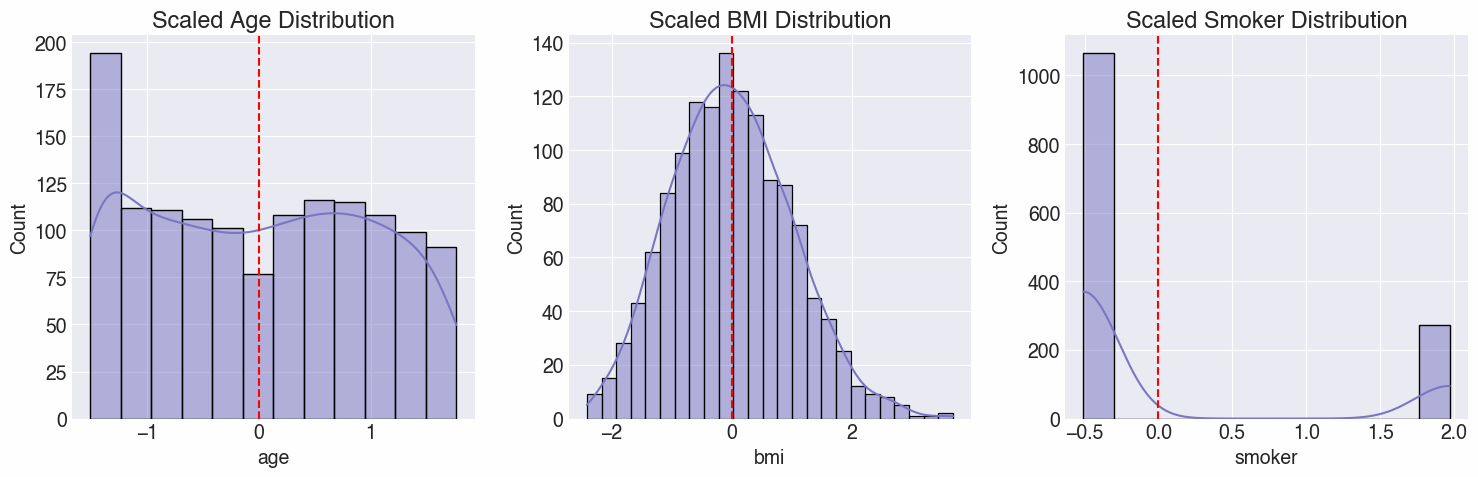

In [77]:
# check if scaling worked properly - should be close to mean=0, std=1 for each column
print("Means of scaled features:")
print(scaled_df.mean())
print("\nStandard deviations of scaled features:")
print(scaled_df.std())

# check the range of values (should generally be within ±3 for most data points)
print("\nMinimum values:")
print(scaled_df.min())
print("\nMaximum values:")
print(scaled_df.max())

# visualize the distribution of a few key scaled features
plt.figure(figsize=(15, 5))

plt.subplot(131)
sns.histplot(scaled_df['age'], kde=True)
plt.title('Scaled Age Distribution')
plt.axvline(x=0, color='r', linestyle='--')

plt.subplot(132)
sns.histplot(scaled_df['bmi'], kde=True)
plt.title('Scaled BMI Distribution')
plt.axvline(x=0, color='r', linestyle='--')

plt.subplot(133)
sns.histplot(scaled_df['smoker'], kde=True)
plt.title('Scaled Smoker Distribution')
plt.axvline(x=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

- centered distributions (means $≈ 0$)
- similar spreads for all features (standard deviations $≈ 1$)
- no extreme values that would suggest scaling errors $(-2.41 > 0 > 4.76)$

##Training